In [1]:
import numpy as np

In [3]:
# decision stump used as weak classifier

class DecisionStump:
    def __init__(self):
        self.polarity = 1
        self.feature_idx = None
        self.threshold = None
        self.alpha = None

    def predict(self, X):
        n_samples = X.shape[0]
        X_column = X[:, self.feature_idx]
        predictions = np.ones(n_samples)
        if self.polarity ==1:
            predictions[X_column < self.threshold] = -1
        else:
            predictions[X_column > self.threshold] = -1
        return predictions 
        


Weighted Error Calculation:
In Adaboost, misclassification errors are weighted based on the importance of each sample.
Initially, all samples have equal weights, but these weights are updated at each iteration based on the performance of the weak classifier.
Misclassified samples contribute more to the error if they have higher weights.

Updating Weights:
After making predictions with the weak classifier, the algorithm calculates the misclassification error using the weighted samples.
The misclassified samples are identified by comparing the true labels y with the predicted labels predictions.
The weights of misclassified samples are then used to calculate the weighted error.

Importance of Weighted Samples:
Using weighted samples allows Adaboost to focus more on the difficult-to-classify samples in subsequent iterations.
Samples that are consistently misclassified by weak classifiers are given higher weights, making them more influential in training subsequent weak classifiers.

In [5]:
class Adaboost:
    def __init__(self, n_clf=5):
        self.n_clf = n_clf # no of weakclassifiets
        self.clfs = [] # list of weak classifiers

    def fit(self, X, y):
        n_samples, n_features = X.shape

        # Initialize weights to 1/N
        w = np.full(n_samples, (1/n_samples))
        self.clfs = []

        # Iterate through classifiers
        for _ in range(self.n_clf):
            clf = DecisionStump()
            min_error = float("inf")


            # greedy search to find exhaustively best threshold and feature
            for feature_i in range(n_features):
                X_column = X[:, feature_i] #  one-dimensional array containing the values of the current feature across all samples.
                # necessary for the subsequent step of performing a greedy search to find the best threshold for splitting the data based on this feature.
                thresholds = np.unique(X_column)

                for threshold in thresholds:
                    # predict with polarity 1
                    p =1
                    predictions = np.ones(n_samples) # initial
                    predictions[X_column < threshold] = -1

                    # error = sum of weights of misclassified samples
                    misclassified = w[y != predictions]
                    error = sum(misclassified)

                    # store the best config
                    if error < min_error:
                        clf.polarity = p
                        clf.threshold = threshold
                        clf.feature_idx = feature_i
                        min_error = error


        
        # calculate alpha
        EPS = 1e-10
        clf.alpha = 0.5 * np.log((1.0 - min_error + EPS) / (min_error + EPS)) 
                                 
        # calculate predictions and update weights
        predictions = clf.predict(X)
        w *= np.exp(-clf.alpha * y * predictions)
        # Normalize to one
        w /= np.sum(w)

        # save classifier
        self.clfs.append(clf)

    def predict(self, X):
    # Predict using the trained Adaboost model
        clf_preds = [clf.alpha * clf.predict(X) for clf in self.clfs]
        y_pred = np.sum(clf_preds, axis=0)
        y_pred = np.sign(y_pred)

        return y_pred
    



In [7]:
# Testing
if __name__ == "__main__":
    # imports
    from sklearn import datasets
    from sklearn.model_selection import train_test_split

    def accuracy(y_true, y_pred):
        accuracy = np.sum(y_true == y_pred)/ len(y_true)
        return accuracy
    
    data = datasets.load_breast_cancer()
    X, y = data.data, data.target

    y[y == 0] = -1

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

    #Adaboost classification with 5 weak classifiers
    clf = Adaboost(n_clf=5)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy(y_test, y_pred)
    print("Accuracy:", acc)

 

Accuracy: 0.6052631578947368


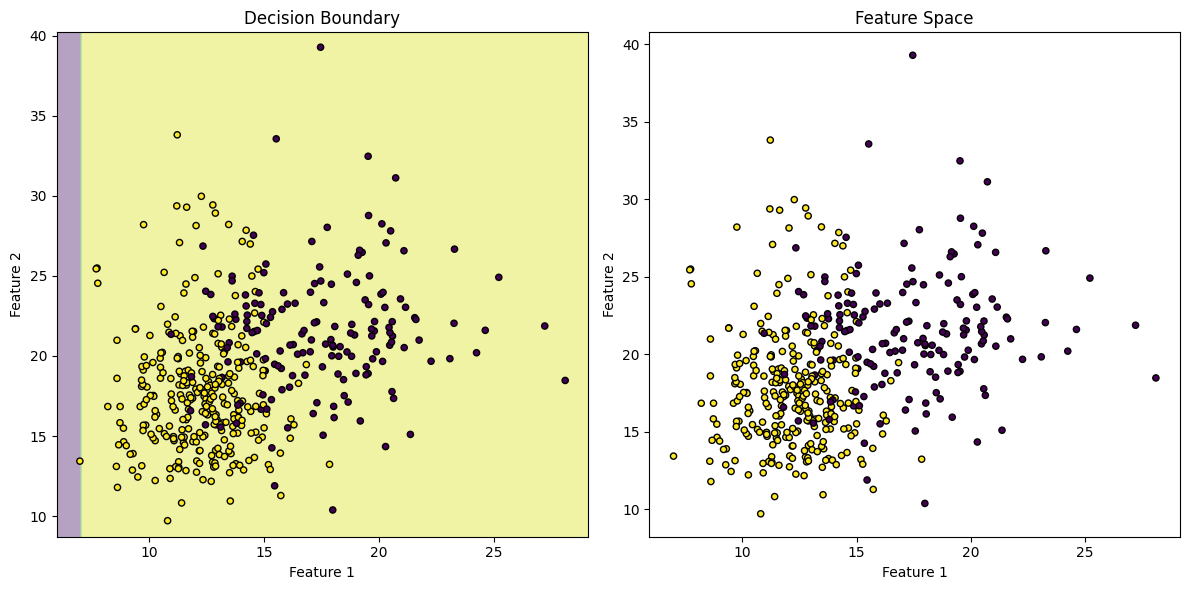

In [8]:
import matplotlib.pyplot as plt

def plot_decision_boundary(X, y, clf):
    # Plot decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary')

def plot_feature_space(X, y, clf):
    # Plot feature space
    plt.scatter(X[:, 0], X[:, 1], c=y, s=20, edgecolor='k')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Feature Space')

# Assuming X_train has shape (n_samples, 2)
X_train_2d = X_train[:, :2]

# Adaboost classification with 5 weak classifiers
clf = Adaboost(n_clf=5)
clf.fit(X_train_2d, y_train)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plot_decision_boundary(X_train_2d, y_train, clf)

plt.subplot(1, 2, 2)
plot_feature_space(X_train_2d, y_train, clf)

plt.tight_layout()
plt.show()
